Original paper: https://arxiv.org/abs/1806.00035

# 0. Read real and generated images#

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

In [0]:
CHANNEL_NUM = 3
PICTURE_SIZE = 36


In [0]:
class ParticleDataset():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = self.data['Pictures'].reshape(-1, CHANNEL_NUM*PICTURE_SIZE*PICTURE_SIZE)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "Pictures": self.image[i],
        }

In [0]:
real_data = ParticleDataset('real.npz')
vae_data = ParticleDataset('vae.npz')
gan_data = ParticleDataset('gan.npz')

Make sure that the values of real and generated data are of the same order - it is important for cooperative binarizing

In [5]:
print (np.min(real_data.image), np.max(real_data.image))
print (np.min(gan_data.image), np.max(gan_data.image))
print (np.min(vae_data.image), np.max(vae_data.image))

0.0 1.0
0.0 1.0
0.0 1.0


# 1. Binarize# 

To understand how real and generated objects are close to each other, we need to choose a space of features in which we look these objects at

We go the easiest way and take pixels' values as features.

In [0]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import math
from scipy.stats import norm
## function which map object to probability distribution ##

def bin_counts (real_data, generated_data, number_of_bins=25):
    # binirize real and generated data, plot histogram and found density function
    
    # Flatten the data
    real_data = real_data.flatten()
    generated_data = generated_data.flatten()
    x = np.linspace(0, 1, 1000)
    # binirize real and generated data, plot histogram and found density function
    plt.figure()
    plt.hist(real_data, bins=number_of_bins, color='g', density=True, stacked=True)
    real_density = norm.pdf(x, np.mean(real_data), np.std(real_data))
    plt.plot(x, real_density, 'k', linewidth=2)
    plt.title("Real Data Distribution")
    plt.show()
    
    plt.figure()
    plt.hist(generated_data.flatten(), bins=number_of_bins, color='b', density=True)
    gen_density = norm.pdf(x, np.mean(generated_data), np.std(generated_data))
    plt.plot(x, gen_density, 'k', linewidth=2)
    plt.title("Generated Data Distribution")
    plt.show()
    
    return real_density / real_density.sum(), gen_density / gen_density.sum()

Create $\alpha-$ and $\beta-$ vectors as in

$\hat{PRD}(Q,P) = \{(\alpha(\lambda), \beta(\lambda))| \lambda \in \Lambda \}$, where $\Lambda = \{\tan (\frac{i}{m+1} \frac{\pi}{2}) | i = 1, 2 ... m\}$

In [0]:
def count_alpha_beta (real_density, gen_density, num_angles = 1000):
    assert real_density.shape == gen_density.shape
    alpha_vec = []
    beta_vec = []
    angles = np.linspace(1e-6, np.pi/2 - 1e-6, num=num_angles)
    for a in angles:
        tg = np.tan(a)
        alpha = np.minimum(tg * real_density, gen_density).sum()
        alpha_vec.append(alpha)
        beta = np.minimum(real_density, gen_density / tg).sum()
        beta_vec.append(beta)
    return alpha_vec, beta_vec

For stability, take the average of several repetitions

In [0]:
def count_prd(reals, gens, repeat_number = 10):
    vectors = [count_alpha_beta(reals, gens) for i in range(repeat_number)]
    vectors = np.array(vectors).mean(axis=0)
    print (vectors.shape)
    return vectors

## 2. Apply it##

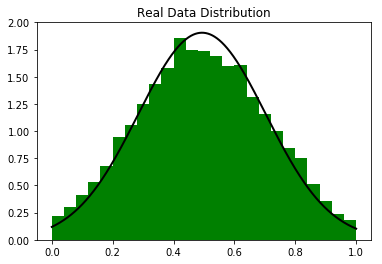

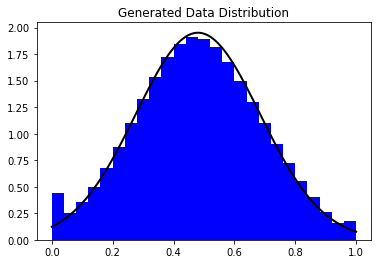

In [22]:
a, b = bin_counts(real_data.image, vae_data.image)

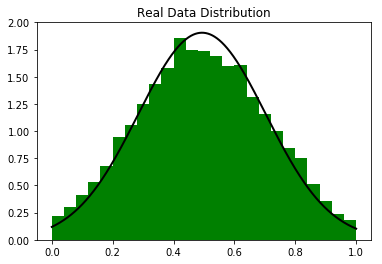

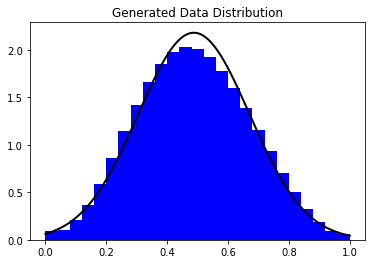

In [23]:
c, d = bin_counts(real_data.image, gan_data.image)

## 3. Make vectors for plot and plot ##

In [24]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(c, d)

(2, 1000)
(2, 1000)


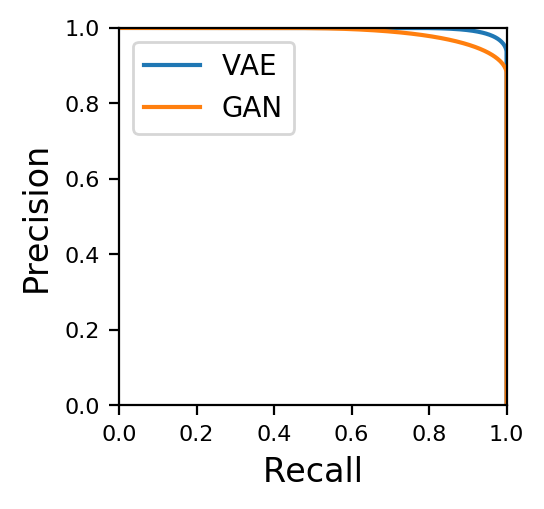

In [25]:
fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
fig.add_subplot(111).tick_params(axis='both', which='major', labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0], data_for_plots[1], label = "VAE")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "GAN")
plt.legend()
plt.show()

**What curves were obtained for the first(VAE) and the second(GAN) models? What can we say about the advantages and disadvantages of each model?**

It seems like I've got VAE better than GAN. I think this is because of early stopping. I believe gan could perform better than VAE.

VAE tries to find a low-dimensional representation of the data conditioned upon a specific input. GAN tries to create representations that are sufficient to generalize the true data distribution conditioned upon a discriminator.

## Bonus: about features' space##

It is possible to transfer the picture-> embedding, for example, using the 1st part of the Inception network as a feature extraxtor. This embedding can be used for bin counts also

In [0]:
# if you came here and still alive, the implementation of idea above will give you extra points =)
